In [1]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import model
from model import header

In [8]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


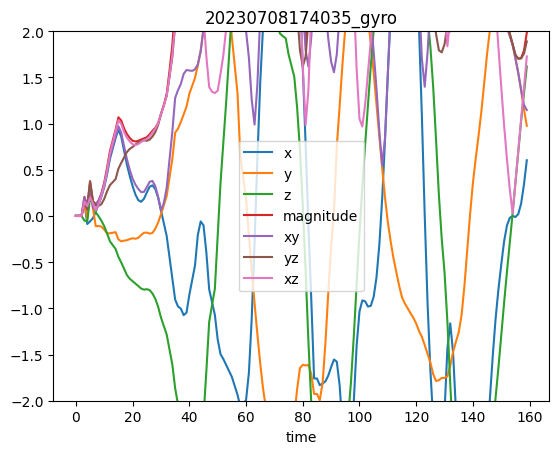

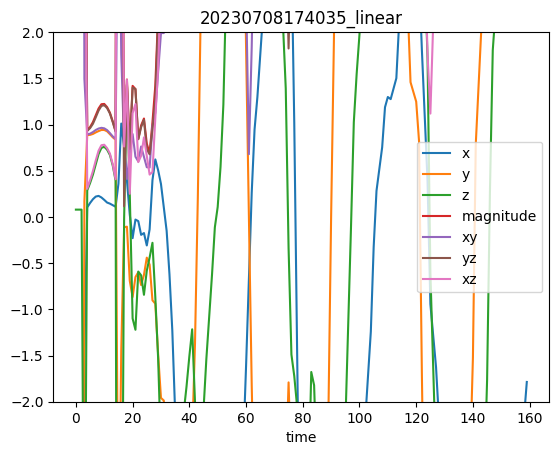

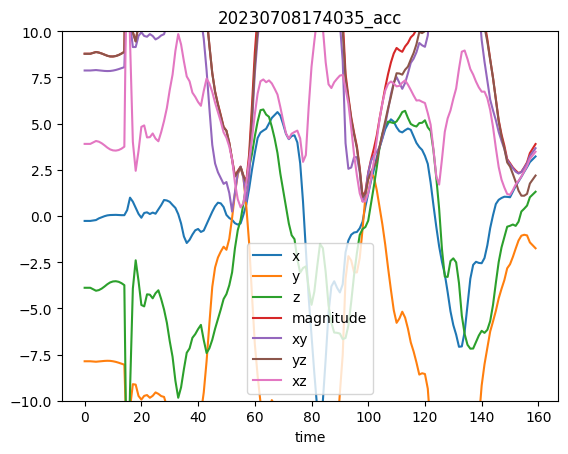

In [3]:
from model import interpolate_data


def visualize(identifier, sensor, gestureName):
    data = pd.read_csv(f'data\\{gestureName}\\{identifier}_{sensor}.csv', names=header)
    p_data = interpolate_data(data)
    ylim = (-2, 2)
    if sensor == "acc":
        ylim = (-10, 10)
    p_data.plot(title=f"{identifier}_{sensor}", ylim=ylim)
identifier = "20230708174035"
gesture = "circle_in"
visualize(identifier, "gyro", gesture)
visualize(identifier, "linear", gesture)
visualize(identifier, "acc", gesture)

<Axes: title={'center': '20230708173456_circle_in'}>

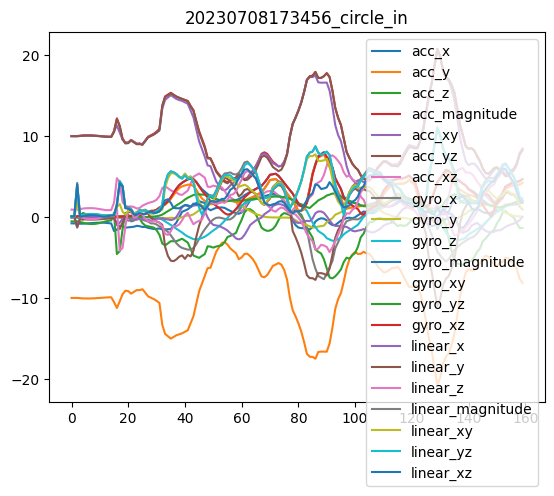

In [4]:
from model import merge_sensors_from_file
identifier = "20230708173456"
gesture = "circle_in"

merge_sensors_from_file(identifier, gesture).plot(title=f"{identifier}_{gesture}")

In [9]:
from model import preprocess_X, preprocess_y, merge_sensors_3d_from_file, merge_sensors_from_file, get_dummy
X = []
y = []
for gestureName in os.listdir("data"):
    # get files in folder
    identifiers = set()
    for fileName in os.listdir(f"data\\{gestureName}"):
        identifier = fileName.split("_")[0]
        identifiers.add(identifier)
    for identifier in identifiers:
        X.append(merge_sensors_from_file(identifier, gestureName))
        y.append(gestureName)

# convert data to numpy
X = preprocess_X(X)
y = preprocess_y(y)

print(len(X))
print(len(y))
y

ImportError: cannot import name 'preprocess_X' from 'model' (d:\Code\Drafts\mochat\data-collector\Server\model.py)

In [40]:
# use sklearn to split dataset
from sklearn.model_selection import train_test_split

# split dataset into training and 'remaining data'
X_train, X_rem, y_train, y_rem = train_test_split(X, y, test_size=0.3)

# split remaining data into test and valid sets
X_valid, X_test, y_valid, y_test = train_test_split(X_rem, y_rem, test_size=0.5)
X_train.shape, X_valid.shape, X_test.shape

((211, 160, 21), (45, 160, 21), (46, 160, 21))

In [66]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPool1D, LSTM, Bidirectional, MaxPooling2D, Conv1D

"""
def create_model():
  model = tf.keras.Sequential()
  
  model.add(LSTM(32, return_sequences=True, input_shape=X_train.shape[1:]))
  
  model.add(LSTM(32))

  model.add(Dense(32, activation="relu"))

  model.add(Dense(len(labels)))
  model.add(Activation("softmax"))

  model.compile(optimizer='adam',
              loss = "categorical_crossentropy",
              metrics=['accuracy'])
  
  return model

"""

def create_model():
  model = tf.keras.Sequential()
  
  model.add(Conv1D(128, 3, input_shape=X.shape[1:]))
  model.add(Activation("relu"))
  model.add(MaxPool1D(pool_size=3))

  model.add(Conv1D(82, 3))
  model.add(Activation("relu"))
  model.add(MaxPool1D(pool_size=3))

  model.add(Conv1D(64, 3))
  model.add(Activation("relu"))
  model.add(MaxPool1D(pool_size=3))


  model.add(Flatten())
  model.add(Dense(64))

  model.add(Dense(len(labels)))
  model.add(Activation("softmax"))

  model.compile(optimizer='adam',
              loss = "categorical_crossentropy",
              metrics=['accuracy'])
  
  return model



# create convolution model
model = create_model()
model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_12 (Conv1D)          (None, 158, 128)          8192      
                                                                 
 activation_30 (Activation)  (None, 158, 128)          0         
                                                                 
 max_pooling1d_12 (MaxPoolin  (None, 52, 128)          0         
 g1D)                                                            
                                                                 
 conv1d_13 (Conv1D)          (None, 50, 82)            31570     
                                                                 
 activation_31 (Activation)  (None, 50, 82)            0         
                                                                 
 max_pooling1d_13 (MaxPoolin  (None, 16, 82)           0         
 g1D)                                                

Epoch 1/100
4/4 - 3s - loss: 2.6135 - accuracy: 0.2464 - val_loss: 1.8235 - val_accuracy: 0.2000 - 3s/epoch - 747ms/step
Epoch 2/100
4/4 - 0s - loss: 1.6029 - accuracy: 0.3507 - val_loss: 1.1622 - val_accuracy: 0.6222 - 329ms/epoch - 82ms/step
Epoch 3/100
4/4 - 0s - loss: 1.1312 - accuracy: 0.5829 - val_loss: 0.9935 - val_accuracy: 0.7111 - 432ms/epoch - 108ms/step
Epoch 4/100
4/4 - 0s - loss: 0.8865 - accuracy: 0.7204 - val_loss: 0.6909 - val_accuracy: 0.7556 - 347ms/epoch - 87ms/step
Epoch 5/100
4/4 - 0s - loss: 0.6358 - accuracy: 0.7488 - val_loss: 0.5447 - val_accuracy: 0.8667 - 326ms/epoch - 82ms/step
Epoch 6/100
4/4 - 0s - loss: 0.4468 - accuracy: 0.8673 - val_loss: 0.5213 - val_accuracy: 0.8889 - 292ms/epoch - 73ms/step
Epoch 7/100
4/4 - 0s - loss: 0.3166 - accuracy: 0.9336 - val_loss: 0.4237 - val_accuracy: 0.8889 - 328ms/epoch - 82ms/step
Epoch 8/100
4/4 - 0s - loss: 0.2417 - accuracy: 0.9526 - val_loss: 0.3954 - val_accuracy: 0.8889 - 412ms/epoch - 103ms/step
Epoch 9/100
4/4 

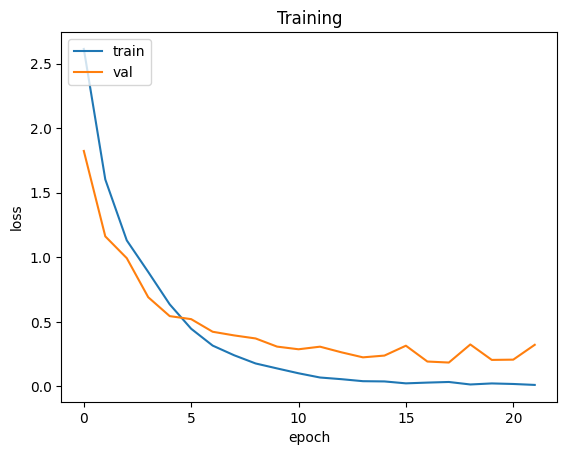

In [67]:
import datetime
def display_training_history(history, title):
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title(title)
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, min_delta=0.0001)
timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
checkpoint_path = f"checkpoints/{timestamp}/"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,save_weights_only=True, monitor='val_loss', mode='min',save_best_only=True)

train_history = model.fit(
    X_train, 
    y_train,
    epochs = 100,
    validation_data = (X_valid, y_valid),
    verbose = 2,
    callbacks=[early_stopping,checkpoint],
    batch_size=64)

model.load_weights(checkpoint_path)
display_training_history(train_history, "Training")

In [68]:
# create classification report
from sklearn.metrics import classification_report
y_pred = model.predict(X_test)

pred_classes = [index_to_label[i] for i in np.argmax(y_pred, axis=1)]
true_classes = [index_to_label[i] for i in np.argmax(y_test, axis=1)]
print(classification_report(true_classes, pred_classes))

2/2 [==============================] - 0s 11ms/step
              precision    recall  f1-score   support

   circle_in       1.00      1.00      1.00         8
  circle_out       1.00      1.00      1.00         8
        down       1.00      1.00      1.00         8
        left       1.00      1.00      1.00         7
       right       1.00      1.00      1.00         7
          up       1.00      1.00      1.00         8

    accuracy                           1.00        46
   macro avg       1.00      1.00      1.00        46
weighted avg       1.00      1.00      1.00        46



<Axes: >

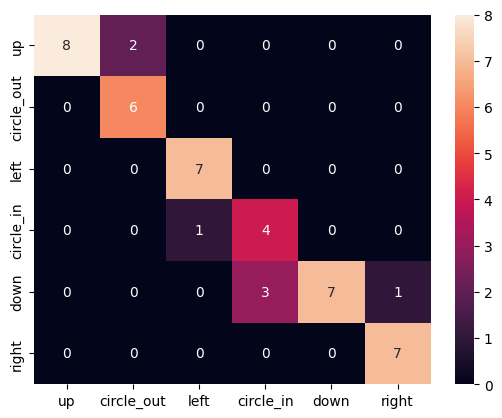

In [63]:
# create confusion matrix
from sklearn.metrics import confusion_matrix


matrix = confusion_matrix(pred_classes, true_classes)
# use sns to plot confusion matrix
sns.heatmap(matrix.tolist(), annot=True, fmt='g', xticklabels=set(labels), yticklabels=set(labels))

In [14]:
import pickle
timestamp = pd.Timestamp.now().strftime("%Y%m%d%H%M%S")
file_name = f"saved_models/knn_{timestamp}.sav"
pickle.dump(knn, open(file_name, 'wb'))